In [25]:
import numpy as np
from scipy.stats import norm
from stochoptim.scengen.scenario_tree import ScenarioTree
from stochoptim.scengen.scenario_process import ScenarioProcess

We illustrate on a Geometric Brownian Motion (GBM) the numerous ways to build (non-optimized) scenario trees.

# 1. Define a `ScenarioProcess` for the GBM

In [2]:
S_0 = 2 # initial value (at stage 0)
delta_t = 1 # time lag between 2 stages
mu = 0 # drift
sigma = 1 # volatility

The `gbm_recurrence` function below implements the dynamic relation of a GBM:  
* $S_{t} = S_{t-1} \exp[(\mu - \sigma^2/2) \Delta t + \sigma  \epsilon_t\sqrt{\Delta t}]$  

where $\epsilon_t$ is a standard normal random variable $N(0,1)$.

In [3]:
def gbm_recurrence(stage, epsilon, scenario_path):
    if stage == 0:
        return {'S': np.array([S_0])}
    else:
        return {'S': scenario_path[stage-1]['S'] \
                        * np.exp((mu - sigma**2 / 2) * delta_t + sigma * np.sqrt(delta_t) * epsilon)}

### Monte Carlo (MC) sampling of $N(0,1)$

In [4]:
def epsilon_sample_mc(n_samples, stage):
    return np.random.normal(0, 1, size=(n_samples, 1))

In [5]:
gbm_mc = ScenarioProcess(gbm_recurrence, epsilon_sample_mc)

In [6]:
weights, epsilon = gbm_mc.get_epsilon_sample(n_samples=4, stage=2)
print("weights", weights)
print("epsilon", epsilon)

weights [0.25 0.25 0.25 0.25]
epsilon [[ 1.12423444]
 [-0.68095472]
 [ 1.22847954]
 [-1.60294173]]


### Quasi-Monte Carlo (QMC) discretization of $N(0,1)$

In [7]:
def epsilon_sample_qmc(n_samples, stage, u=0.5):
    return norm.ppf(np.linspace(0, 1-1/n_samples, n_samples) + u / n_samples).reshape(-1, 1)

In [8]:
gbm_qmc = ScenarioProcess(gbm_recurrence, epsilon_sample_qmc)

In [9]:
weights, epsilon = gbm_qmc.get_epsilon_sample(n_samples=4, stage=2)
print("weights", weights)
print("epsilon", epsilon)

weights [0.25 0.25 0.25 0.25]
epsilon [[-1.15034938]
 [-0.31863936]
 [ 0.31863936]
 [ 1.15034938]]


# 2. Build a `ScenarioTree` filled with GBM values

### Scenario tree `from_bushiness` filled via MC points

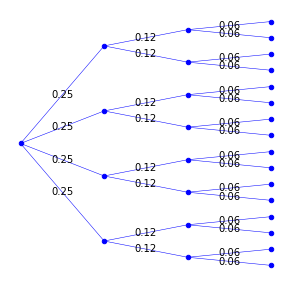

In [10]:
scen_tree_mc = ScenarioTree.from_bushiness([4,2,2])
scen_tree_mc.fill(gbm_mc)
scen_tree_mc.plot('bm', scenario_precision=2, format_weights='.2f')

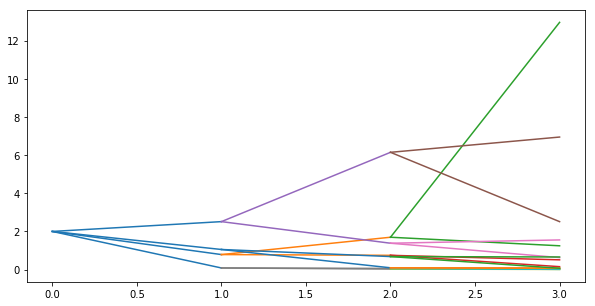

In [11]:
scen_tree_mc.plot_scenarios('S')

### Scenario tree `from_bushiness` filled via QMC points

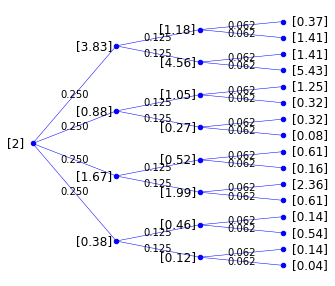

In [12]:
scen_tree_qmc = ScenarioTree.from_bushiness([4,2,2])
scen_tree_qmc.fill(gbm_qmc)
scen_tree_qmc.plot("S")

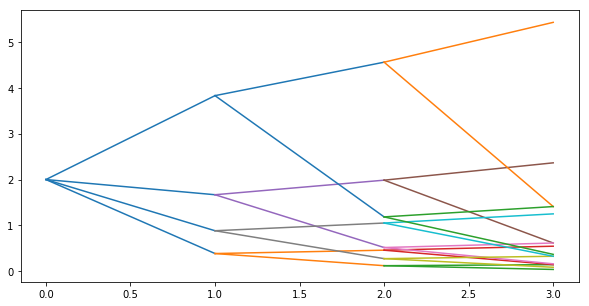

In [13]:
scen_tree_qmc.plot_scenarios('S')

### Scenario tree `from_topology` filled via MC points

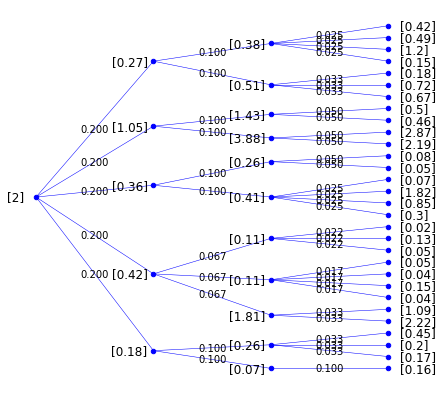

In [14]:
scen_tree_mc = ScenarioTree.from_topology([[1,3], [2,4,3], [4,2], [2,2], [3,4]])
scen_tree_mc.fill(gbm_mc)
scen_tree_mc.plot('S', figsize=(7,7))

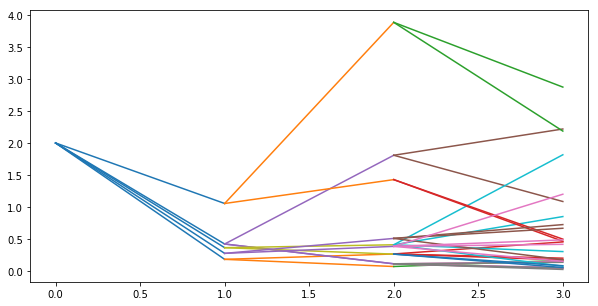

In [15]:
scen_tree_mc.plot_scenarios('S')

### Scenario tree `from_topology` filled via QMC points

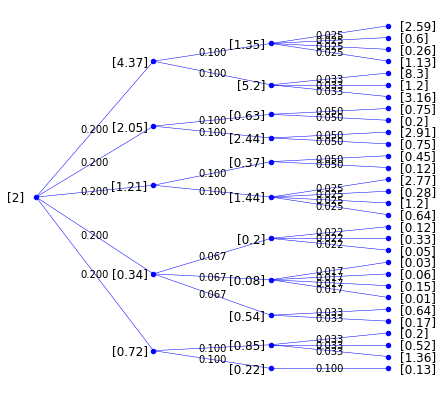

In [16]:
scen_tree_qmc = ScenarioTree.from_topology([[1,3], [2,4,3], [4,2], [2,2], [3,4]])
scen_tree_qmc.fill(gbm_qmc)
scen_tree_qmc.plot('S', figsize=(7,7))

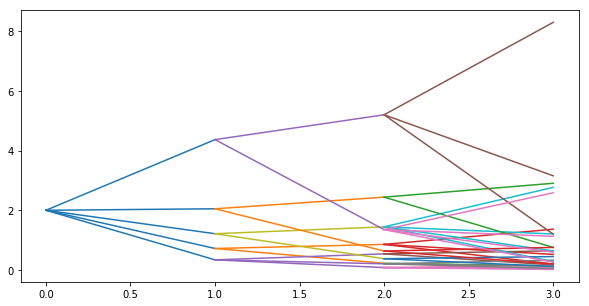

In [17]:
scen_tree_qmc.plot_scenarios('S')

### Scenario tree `from_recurrence` filled via MC points

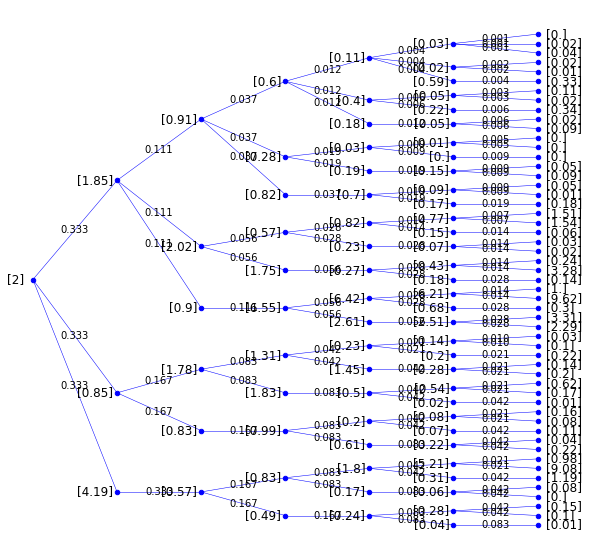

In [18]:
scen_tree_mc = ScenarioTree.from_recurrence(last_stage=6, init=3, recurrence={1: (2,), 2: (1,2), 3: (1,2,3)})
scen_tree_mc.fill(gbm_mc)
scen_tree_mc.plot('S', figsize=(10,10))

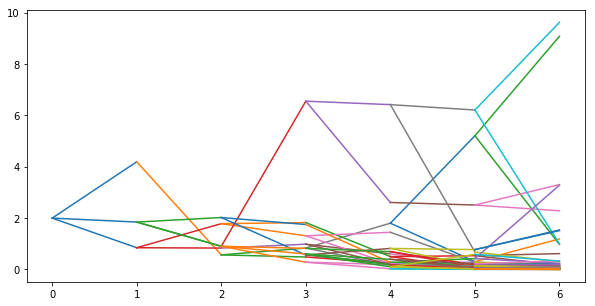

In [19]:
scen_tree_mc.plot_scenarios('S')

### Scenario tree `from_recurrence` filled via QMC points

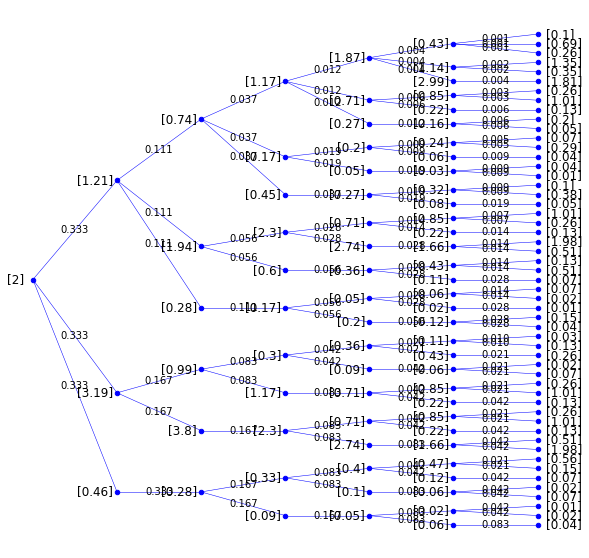

In [20]:
scen_tree_qmc = ScenarioTree.from_recurrence(last_stage=6, init=3, recurrence={1: (2,), 2: (1,2), 3: (1,2,3)})
scen_tree_qmc.fill(gbm_qmc)
scen_tree_qmc.plot('S', figsize=(10,10))

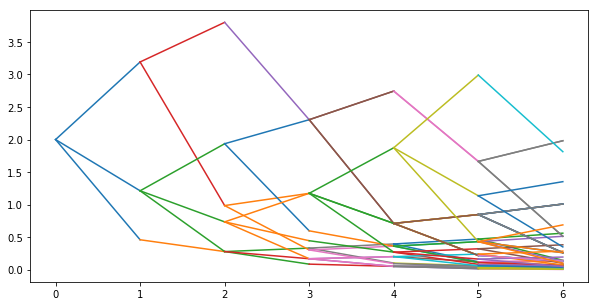

In [21]:
scen_tree_qmc.plot_scenarios('S')

# Scenario Trees built directly from scenarios

In [22]:
n_scenarios = 10
last_period = 5
epsilon = np.random.normal(0, 1, size=(n_scenarios, last_period))
gbm_scenarios = np.cumprod(np.exp((mu - sigma**2 / 2) * delta_t + sigma * np.sqrt(delta_t) * epsilon), axis=1)
gbm_scenarios

array([[2.71849840e-01, 1.27809250e+00, 2.33299359e+00, 6.24062421e+00,
        3.20027994e+00],
       [4.12461727e-01, 1.18535642e-01, 1.43733365e-02, 1.20426686e-02,
        7.22248289e-02],
       [1.38617928e+00, 4.28497869e-01, 9.11942419e-01, 7.59563481e-02,
        2.39486017e-01],
       [6.66036543e-01, 4.01866193e-01, 3.94904926e-01, 8.61451127e-02,
        2.56310155e-02],
       [1.22704364e+00, 4.05264605e-01, 5.60670951e-01, 2.81943712e-01,
        3.02536319e-02],
       [2.51214197e+00, 4.95477827e+00, 9.85306380e+00, 4.73245231e+00,
        1.44972753e+00],
       [1.48745192e+00, 1.66731289e+00, 5.63936639e-01, 8.15400376e-02,
        4.80766452e-01],
       [3.52886772e-01, 5.19094548e-02, 2.61610875e-02, 2.15294109e-02,
        1.65630760e-02],
       [6.26937283e-01, 9.42114731e-01, 3.39425862e+00, 4.15343860e+00,
        3.74392690e+00],
       [3.32192078e-01, 6.62642252e-02, 1.56810385e-02, 7.72034094e-03,
        1.55206954e-03]])

###  Two-stage Scenario tree (`twostage_from_scenarios`)

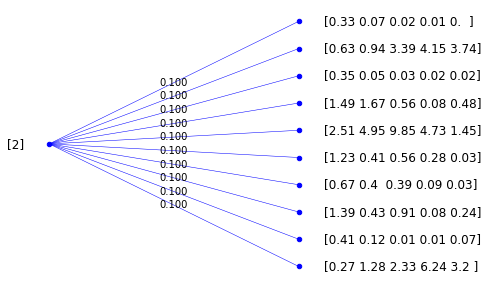

In [23]:
two_stage_scen_tree = ScenarioTree.twostage_from_scenarios(scenarios=gbm_scenarios, n_rvar={'S': last_period})
two_stage_scen_tree.data['scenario'] = {'S': np.array([S_0])} # add value at root node
two_stage_scen_tree.plot('S')

### Multistage scenario tree (`combtree_from_scenarios`)

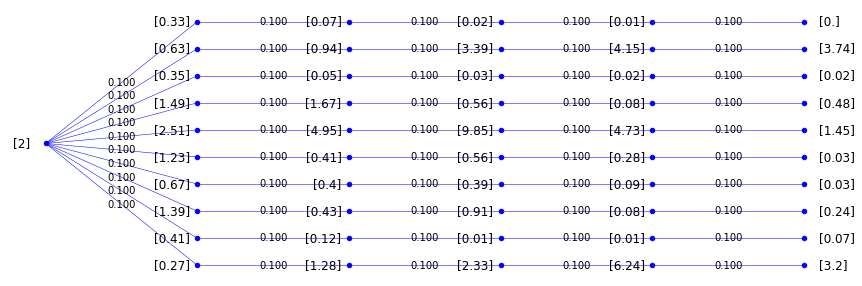

In [24]:
comb_scen_tree = ScenarioTree.combtree_from_scenarios(scenarios=gbm_scenarios,
                                                     map_stage_to_rvar_nb={i: {'S': 1} for i in range(1, last_period+1)})
comb_scen_tree.data['scenario'] = {'S': np.array([S_0])} # add value at root node
comb_scen_tree.plot('S', figsize=(15,5))